## train 3D UNet on single molecule dataset; with deeper Unet

### load data

In [1]:
import os 
import numpy as np
# from dataGenerator import imageLoader
from dataGenerator import imageLoaderDeep
import keras
import matplotlib.pyplot as plt
import glob
import random

In [2]:
# visualize

def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    # plt.title('focal slice')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    # plt.title('GT slice')
    plt.show()

In [3]:
# generate the gif

import numpy as np
from PIL import Image
import SimpleITK as sitk
import mrcfile

def saveGIF(imageGIF, labelGIF, predict, direction, gif_directory):
    
    # print('during gif') 
    
    imageGIF = imageGIF  # the original dataset is 8 bits
    stack = []
    
    # print(image.shape, label.shape, predict.shape)
    # print('image:', np.max(imageGIF), np.min(imageGIF))
    # print('label after gif: ', np.max(labelGIF), np.min(labelGIF))
    # print('predict: ', np.max(predict), np.min(predict))
    
    bar = np.ones((imageGIF.shape[0], 10)) # divide the images
    
    if direction == 0:
        print('cut along x')
    elif direction == 1:
        print('cut along y')

    elif direction == 2:
        print('cut along z')
        
    else:
        print('please specify the direction')
    
    
    for i in range(imageGIF.shape[0]):
        
        # print('image slice:', i)
        # temp1 = imageGIF[i,...]
        # temp2 = predict[i,...]
        # temp3 = labelGIF[i,...]
        # print('cut along x')

        if direction == 0:
            temp1 = imageGIF[i,...]
            temp2 = predict[i,...]
            temp3 = labelGIF[i,...]
            
        elif direction == 1:
            temp1 = imageGIF[:,i,:]
            temp2 = predict[:,i,:]
            temp3 = labelGIF[:,i,:]
        
        elif direction == 2:
            temp1 = imageGIF[...,i]
            temp2 = predict[...,i]
            temp3 = labelGIF[...,i]
        else:
            print('illegal cut')
        
        
        # print('round:', i)
        # print('image concatenate:', temp1.shape)
        # print('label concatenate:', temp2.shape)
        # print('predict concatenate:', temp3.shape)
        
        imageTemp = np.concatenate((temp1, bar, temp2, bar, temp3), axis=1)
        # print('after concatenate:', imageTemp.shape)
        stack.append(imageTemp)
        
    stack = np.asarray(stack)
    
    # imgs = [img*255 for img in stack]
    imgs = [Image.fromarray(img*255) for img in stack]  # pil要求整体图片乘上255
    # duration is the number of milliseconds between frames; this is 40 frames per second
    imgs[0].save(gif_directory, save_all=True, append_images=imgs[1:], duration=50, loop=0)
    
    # write as nii
    # writer = sitk.ImageFileWriter()
    # writer.SetFileName('./results/result.nii')
    # writer.Execute(stack)
    
    mrc = mrcfile.new('./results/result.mrc', overwrite=True)
    mrc.set_data((stack*255).astype('int8'))
    mrc.close
    
    np.save('./results/result.npy', stack)
    

In [4]:
# specify the dir

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

num_images = len(train_img_list)
print(num_images)

240


In [5]:
print('image list:', train_img_list[10])
print('mask list:', train_msk_list[10])

image list: E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/train/images\image_110.npy
mask list: E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/train/masks\mask_110.npy


In [6]:
# visualize the images

img_num = random.randint(0, num_images-1) # num从1开始
test_img = np.load(train_img_list[img_num])
test_img = test_img[...,0]
print('image shape:', test_img.shape)

test_mask = np.load(train_msk_list[img_num])
print('before mask:', test_mask.shape)
test_mask = np.argmax(test_mask, axis=3)
print('after mask:', test_mask.shape)

image shape: (64, 64, 64)
before mask: (64, 64, 64, 2)
after mask: (64, 64, 64)


In [7]:
#  reshape data for 2D deep UNet

# test = np.stack([test_mask], axis=3)
# print(test.shape)
test = np.expand_dims(test_mask, axis = -1)
print(test.shape)

(64, 64, 64, 1)


current slice: 32


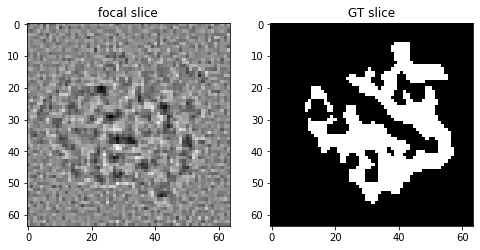

current slice: 34


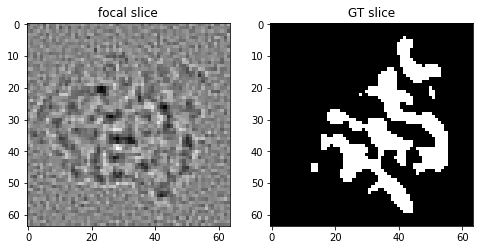

In [8]:
# visualize the images 

# n_slice = random.randint(0, test_mask.shape[2]-1)

n_slice = 32
print('current slice:', n_slice)
visusalizeIMG(n_slice, test_img, test_mask)

print('current slice:', n_slice + 2)
visusalizeIMG(n_slice + 2, test_img, test_mask)

### calculate the weight between labels. useful for weighted dice loss

In [9]:
import pandas as pd

columns = ['0', '1']
df = pd.DataFrame(columns=columns)

train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

for img in range(len(train_msk_list)):
    
    # print(img)
    temp_image = np.load(train_msk_list[img])
    temp_image = np.argmax(temp_image, axis=3)  # convert back into images
    
    val, counts = np.unique(temp_image, return_counts=True) # count labels
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)
    
    df = df.append(counts_dict, ignore_index = True)

In [10]:
# calculate the ratio of different labels

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

# class weight calculated: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) # 小数点后两位
wt1 = round((total_labels/(n_classes*label_1)), 2)

print(wt0, wt1)

0.56 4.4


### define the image generator

In [11]:
# train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
# train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))
# val_img_list = sorted(glob.glob(val_img_dir + '/*.npy'))
# val_msk_list = sorted(glob.glob(val_msk_dir + '/*.npy'))
# test_img_list = sorted(glob.glob(test_img_dir + '/*.npy'))
# test_msk_list = sorted(glob.glob(test_msk_dir + '/*.npy'))

In [12]:
# data path and sort

from natsort import natsorted

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = natsorted(os.listdir(train_img_dir))
train_msk_list = natsorted(os.listdir(train_msk_dir))

# validation
val_img_dir = DATA_PATH + 'val/images/'
val_msk_dir = DATA_PATH + 'val/masks/'

val_img_list = natsorted(os.listdir(val_img_dir))
val_msk_list = natsorted(os.listdir(val_msk_dir))

# testing
test_img_dir = DATA_PATH + 'test/images/'
test_msk_dir = DATA_PATH + 'test/masks/'

test_img_list = natsorted(os.listdir(test_img_dir))
test_msk_list = natsorted(os.listdir(test_msk_dir))

print('train images:', len(train_img_list))
print('val images:', len(val_img_list))
print('test images:', len(test_img_list))

train images: 240
val images: 30
test images: 30


In [13]:
# data generator for training

batch_size = 2

train_img_datagen = imageLoaderDeep(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)

val_img_datagen = imageLoaderDeep(val_img_dir, val_img_list,
                             val_msk_dir, val_msk_list, batch_size)

image gen: (2, 64, 64, 64)
mask gen: (2, 64, 64, 64)
slice num: 32


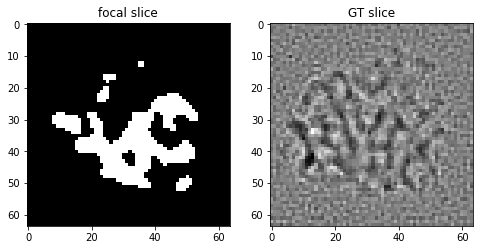

In [14]:
# visualize the data generator

img, msk = train_img_datagen.__next__()
print('image gen:', img.shape)
print('mask gen:', msk.shape)


stack_num = random.randint(0, img.shape[0]-1)
test_img = img[stack_num]
test_mask = msk[stack_num] # whcih stack
# test_mask = np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
n_slice = 32

print('slice num:', n_slice)
visusalizeIMG(n_slice, test_mask, test_img)

### define the loss, metrics and optimizer for training

In [15]:
# wt0, wt1 = 0.5,0.5
wt0, wt1 = 0.56,4.4

# model is 2d, but the loss cal is on 3d volume
import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))  # default is uniform
focal_loss = sm.losses.CategoricalFocalLoss()
BCE_loss = sm.losses.BinaryCELoss()

total_loss = dice_loss*0.005 + (1* focal_loss) + BCE_loss*1  # works for most segmentation jobs

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]  # metrics for final performance
# metrics = [sm.metrics.IOUScore(threshold=0.5)] # only use IoU
# metrics = ['accuracy', sm.metrics.FScore(beta=1)] # F1 score

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [16]:
# 调试用loss function

# loss function designed from scratch

# import tensorflow as tf
# import tensorflow.keras.backend as K

# LR = 0.0001
# optim = keras.optimizers.Adam(LR)


# # soft dice
# def dice_coef(y_true, y_pred, smooth=100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice


# def loss_function(y_true, y_pred):
#     dice_loss = -dice_coef(y_true, y_pred)
#     l1_loss = tf.math.reduce_mean(tf.math.abs(y_true - y_pred), axis=(1,2,3))  # tranfer matrix into value
#     SCE = tf.keras.metrics.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)
    
#     print('SCE shape:', SCE.shape)
    
#     # ssim_loss = tf.image.ssim_multiscale(y_true, y_pred, max_val=1)
    
#     total_loss = dice_loss*0.05 + l1_loss*0.5  + tf.math.reduce_mean(SCE, axis=(1,2))*1  #CE_loss #ssim_loss    # weight should be tuned SCE #
    
    
#     return total_loss



# jaccard_loss = JaccardLoss()
# dice_loss = DiceLoss()

# binary_focal_loss = BinaryFocalLoss()
# categorical_focal_loss = CategoricalFocalLoss()

# binary_crossentropy = BinaryCELoss()
# categorical_crossentropy = CategoricalCELoss()

# # loss combinations
# bce_dice_loss = binary_crossentropy + dice_loss
# bce_jaccard_loss = binary_crossentropy + jaccard_loss

# cce_dice_loss = categorical_crossentropy + dice_loss
# cce_jaccard_loss = categorical_crossentropy + jaccard_loss

# binary_focal_dice_loss = binary_focal_loss + dice_loss
# binary_focal_jaccard_loss = binary_focal_loss + jaccard_loss

# categorical_focal_dice_loss = categorical_focal_loss + dice_loss
# categorical_focal_jaccard_loss = categorical_focal_loss + jaccard_loss

### fit the model

In [17]:
# batch per epochs

steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

print('batch per epochs:', steps_per_epoch)

batch per epochs: 120


In [18]:
# # load model from transfer learning

# from simple3DUnet import simple_unet_model

# model = simple_unet_model(IMG_HEIGHT=64,
#                          IMG_WIDTH=64,
#                          IMG_DEPTH=64,
#                          IMG_CHANNELS=1,
#                          num_classes=1)   # change the num; 2->1. G.

# # model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
# model.compile(optimizer=optim, loss=loss_function, metrics=[dice_coef]) 

# # print(model.summary())
# print(model.input_shape)
# print(model.output_shape)

In [19]:
# from tensorflow.keras.models import Model

In [20]:
# G's Unet model

# from Unet_G import UNet
from model.Unet_G import *

# shape, out_channels=3, inputs=None, full_model=False, z_enc=None
model = UNet((64,64,64), out_channels=64, full_model=True)   # change the num; 2->1. G.

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
# model.compile(optimizer=optim, loss=loss_function, metrics=[dice_coef]) 

# print(model.summary())
print(model.input_shape)
print(model.output_shape)

(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 64)


### train and save model

#### 测试batch 训练

2/2 [==============================] - 1s 7ms/step
0 [0.774956226348877, 0.0074462890625, 0.10208926349878311]


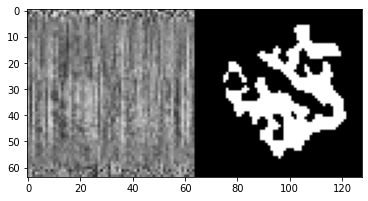

2/2 [==============================] - 0s 15ms/step
1000 [0.5238019824028015, 0.011474609375, 0.3760908842086792]


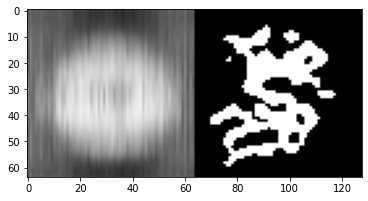

2/2 [==============================] - 0s 15ms/step
2000 [0.3052857220172882, 0.007080078125, 0.4381910264492035]


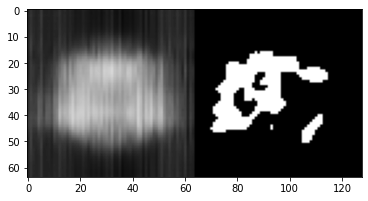

2/2 [==============================] - 0s 14ms/step
3000 [0.23705266416072845, 0.0123291015625, 0.39159438014030457]


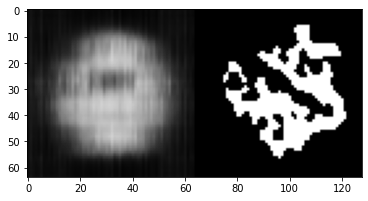

2/2 [==============================] - 0s 15ms/step
4000 [0.17946290969848633, 0.013671875, 0.49768388271331787]


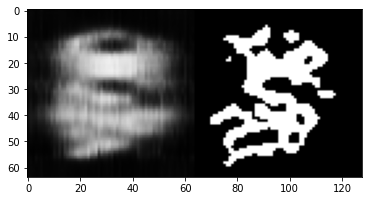

2/2 [==============================] - 0s 14ms/step
5000 [0.14554598927497864, 0.0101318359375, 0.5659414529800415]


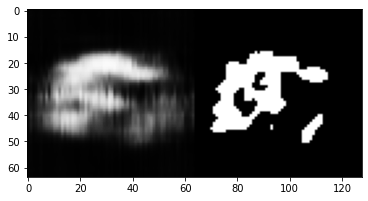

2/2 [==============================] - 0s 15ms/step
6000 [0.14260438084602356, 0.0167236328125, 0.5766454339027405]


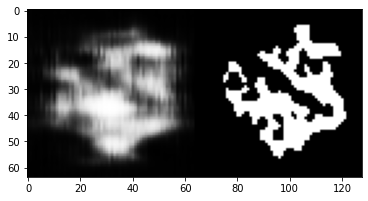

2/2 [==============================] - 0s 16ms/step
7000 [0.11782833188772202, 0.01708984375, 0.6382331848144531]


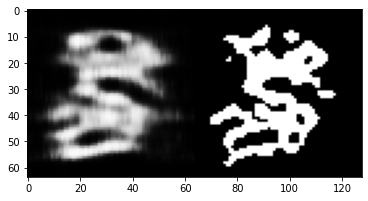

2/2 [==============================] - 0s 14ms/step
8000 [0.0961974486708641, 0.01416015625, 0.7022612690925598]


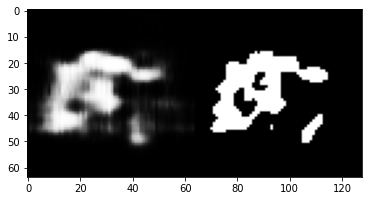

2/2 [==============================] - 0s 14ms/step
9000 [0.10066638141870499, 0.0255126953125, 0.676977276802063]


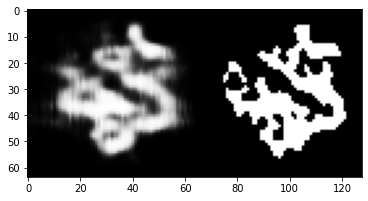

In [21]:
# 测试per batch

# G's unet
# not use the fit. // train_on_batch

NUM_STEPS = 10000

# model.summary()

for step in range(NUM_STEPS):
    
    img, msk = train_img_datagen.__next__()
    
    # 新的generator的形状已经更改了
    # img = np.squeeze(img)
    # msk = np.argmax(msk, axis=-1).astype('float64')  # remove last channel
    # msk = np.expand_dims(mBCE_lossaxis=-1).astype('float64')
    
    loss = model.train_on_batch(img, msk)  # control the way to consume MM
    
    # print(step, loss)
    
    # if step % 10000 == 0:
    #     # model.save_weights('./weight/modelDeep_loss_batch.hdf5')
    #     model.save('./weight/modelDeep_loss_batch.hdf5')  # directly save the whole model
        
    if step % 1000 == 0:
        prediction = model.predict(img,batch_size=1)
        print(step, loss)
        plt.imshow(np.concatenate((prediction[0,32,:,:], msk[0,32,:,:]), axis=1),cmap='gray')
        plt.show()
        plt.close('all')


(2, 64, 64, 64) (2, 64, 64, 64)
slice Num: 62


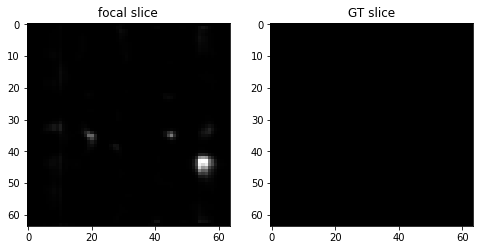

In [29]:
# visualize of last training images

showPred = prediction
showMask = msk
showIMG = img
print(showPred.shape, showMask.shape)
n_slice = random.randint(0, showPred.shape[1])

NUM = 0
print('slice Num:', n_slice)
visusalizeIMG(n_slice, showPred[NUM,...], showMask[NUM,...])

In [30]:
# generate one gif of the stack

NUM = 0
direction = 0
gif_directory = './results/result1.gif'

saveGIF(showIMG[NUM,...].squeeze(), showMask[NUM,...].squeeze(), showPred[NUM,...].squeeze(), direction, gif_directory)


cut along x


#### Train

In [21]:
import tensorflow.keras as k

callbacks = [
    k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = './tensorBoard/2D/1024/')]

In [22]:
# training with deeper 2D U-Net

EPOCHS = 50

history = model.fit(train_img_datagen,
                   steps_per_epoch=steps_per_epoch,
                   epochs=EPOCHS,
                   verbose=1, # ??
                   validation_data=val_img_datagen,
                   validation_steps=val_steps_per_epoch,)


MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/weight/'

model.save(MODEL_PATH + 'deep_2D' + '_' + str(EPOCHS) + '.hdf5')

Epoch 1/50
120/120 [==============================] - 18s 76ms/step - loss: 0.6814 - accuracy: 0.0981 - iou_score: 0.1934 - val_loss: 0.6568 - val_accuracy: 0.2198 - val_iou_score: 0.2224
Epoch 2/50
120/120 [==============================] - 8s 68ms/step - loss: 0.6443 - accuracy: 0.1976 - iou_score: 0.2433 - val_loss: 0.6339 - val_accuracy: 0.1933 - val_iou_score: 0.2593
Epoch 3/50
120/120 [==============================] - 8s 68ms/step - loss: 0.6272 - accuracy: 0.1029 - iou_score: 0.2703 - val_loss: 0.6205 - val_accuracy: 0.0954 - val_iou_score: 0.2833
Epoch 4/50
120/120 [==============================] - 8s 69ms/step - loss: 0.6154 - accuracy: 0.0443 - iou_score: 0.2900 - val_loss: 0.6098 - val_accuracy: 0.0639 - val_iou_score: 0.3020
Epoch 5/50
120/120 [==============================] - 8s 70ms/step - loss: 0.6039 - accuracy: 0.0362 - iou_score: 0.3072 - val_loss: 0.5984 - val_accuracy: 0.0458 - val_iou_score: 0.3157
Epoch 6/50
120/120 [==============================] - 8s 68ms/st

### visualize the training process

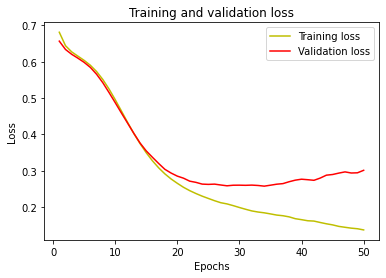

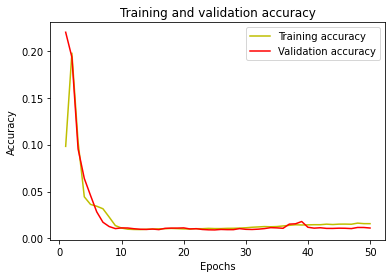

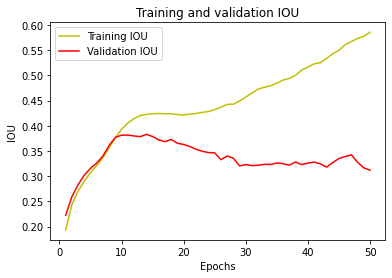

In [23]:
FIG_PATH = './reports/'

# loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(FIG_PATH + '2D_loss.png', dpi=300, bbox_inches = 'tight')
plt.show()

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure()
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(FIG_PATH + '2D_accuracy.png', dpi=300, bbox_inches = 'tight')
plt.show()

# IoU
IoU = history.history['iou_score']
val_iou = history.history['val_iou_score']
plt.figure()
plt.plot(epochs, IoU, 'y', label='Training IOU')
plt.plot(epochs, val_iou, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig(FIG_PATH + '2D_IoU.png', dpi=300, bbox_inches = 'tight')
plt.show()


### predict the test dataset of single image

#### batch测试的模型

In [40]:
# load the test model

from keras.models import load_model

# MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/weight/'

my_model = load_model('./weight/modelDeep_loss_batch.hdf5', compile=False)
# my_model = load_model('./weight/deep_2D_50.hdf5', compile=False)

#### normal training model

In [24]:
# load in the model
from keras.models import load_model

EPOCHS = 50
MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/weight/'

my_model = load_model(MODEL_PATH + 'deep_2D' + '_' + str(EPOCHS) + '.hdf5', compile=False)

In [25]:
# for prediction verify IoU

from keras.metrics import MeanIoU

batch_size = 4  # prediction batch

test_img_datagen = imageLoaderDeep(test_img_dir, test_img_list,
                              test_msk_dir, test_msk_list, batch_size)

In [26]:
# verify the generator

test_image_batch, test_mask_batch = test_img_datagen.__next__()  
print('before:', test_image_batch.shape, test_mask_batch.shape)

before: (4, 64, 64, 64) (4, 64, 64, 64)


In [27]:
# predict

test_pred_batch = my_model.predict(test_image_batch)
print(test_pred_batch.shape)

1/1 [==============================] - 2s 2s/step
(4, 64, 64, 64)


In [28]:
print(test_mask_batch.shape)

(4, 64, 64, 64)


In [29]:
# n_classes = 2

n_classesG = 2
IOU_keras = MeanIoU(num_classes=n_classesG)  
IOU_keras.update_state(test_pred_batch, test_mask_batch)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.44199085


### predict the test dataset of multiple image

In [30]:
test = np.expand_dims(np.squeeze(test_img), axis=0)

print(test_img.shape, test.shape)

(64, 64, 64) (1, 64, 64, 64)


In [31]:
img_num = 15  # the name in test dataset

test_img = np.load(DATA_PATH + '/test/images/image_'+str(img_num)+'.npy')
test_img = np.expand_dims(np.squeeze(test_img), axis=0)

test_mask = np.load(DATA_PATH + '/test/masks/mask_'+str(img_num)+'.npy')
test_msk_argmax = np.argmax(test_mask, axis=3)

test_prediction = my_model.predict(test_img)  # input shape [None, W, H, t]

print(test_prediction.shape, test_msk_argmax.shape, test_img.shape)

1/1 [==============================] - 1s 737ms/step
(1, 64, 64, 64) (64, 64, 64) (1, 64, 64, 64)


In [32]:
print(test_mask.shape)

test_argmax = np.argmax(test_mask, axis=3)
print(test_argmax.shape)

(64, 64, 64, 2)
(64, 64, 64)


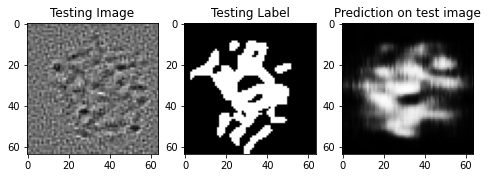

In [33]:
# visualize in x direction

n_slice = 32

plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(np.squeeze(test_img)[n_slice,...], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_msk_argmax[n_slice,...], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(np.squeeze(test_prediction)[n_slice,...], cmap='gray')
plt.show()

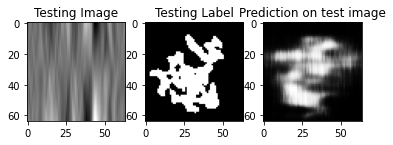

In [34]:
# visualize in y direction

n_slice = 25

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(np.squeeze(test_img)[:,n_slice,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_msk_argmax[:,n_slice,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(np.squeeze(test_prediction)[:,n_slice,:], cmap='gray')
plt.show()